In [23]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

In [24]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')==3:
        temp_id = '.'.join(temp_id.split('.')[0:-1])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')
        
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    #remove protein groups with less thatn 2 unique peptides
    before = df.shape
    col = 'Peptide counts (unique)'
    df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    df = df[df['unique'] >= 2]
    print_result(start, before, df, col)
    return df

In [25]:
#add back the description of the proteins
desc_dict = {}
path = 'TriTrypDB-32_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc

In [27]:
#read data and log transform for plots
df = pd.read_csv('proteinGroups.txt',sep='\t')
df = clean(df)
df.head()
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df['logInt']=np.log10(df['Intensity'])
df['logRatio']=np.log2(df['Ratio H/L normalized'])

removed  52 Only identified by site
tot  52  entries removed
---------------
removed  20 Reverse
tot  72  entries removed
---------------
removed  29 Potential contaminant
tot  101  entries removed
---------------
removed  555 Peptide counts (unique)
tot  656  entries removed
---------------


In [28]:
#get transmembrane and peptide signal from TryTripDB
tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)

df['[Input ID]'] = df['Gene_id']
df.set_index('[Input ID]',inplace=True)
df = df.join(tm, how='left')
df['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df['[SignalP Peptide]'] ] 



In [29]:
#select some fielsd from the full output
selection = df[['Gene_desc', 'Score', 
                'Ratio H/L normalized', 'Intensity', 
                'logInt', 'logRatio','[SignalP Peptide]','[# TM Domains]']]
selection.dropna(inplace=True)
selection.sort_values('logRatio',inplace=True,ascending =False)
selection.head()

,Gene_desc,Score,Ratio H/L normalized,Intensity,logInt,logRatio,[SignalP Peptide],[# TM Domains]
[Input ID],,,,,,,,
Tb927.11.9400,"hypothetical protein, conserved",4.7487,21.2700,1061800,6.026043,4.410748,0,0.0
Tb927.5.1210,"short-chain dehydrogenase, putative",102.8800,13.6010,47788000,7.679319,3.765641,1,2.0
Tb927.11.12080,N-acetyl-D-glucosaminylphosphatidylinositol de...,29.8040,13.2970,3156700,6.499233,3.733029,0,0.0
Tb927.11.6210,Lanosterol 14-alpha demethylase,4.3205,12.7250,4638000,6.666331,3.669594,1,0.0
Tb927.10.4040,3-keto-dihydrosphingosine reductase,6.3210,9.7405,1800500,6.255393,3.283996,1,1.0


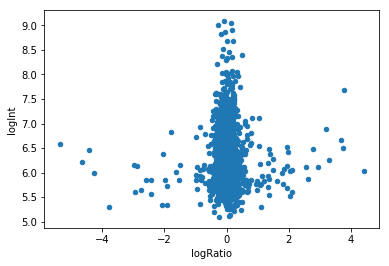

In [30]:
#basic plot
fig,ax = plt.subplots()
selection.plot(kind='scatter', y='logInt',x='logRatio', ax=ax)
fig.savefig('test.png')

In [45]:
#interactive plot
trace = go.Scatter(
    x=selection.logRatio,
    y=selection.logInt,
    mode='markers',
    name='Vulcano Plot',
    text = [a + ' ' +b for a,b in zip(selection.index.values, selection.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = selection.logRatio, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)

layout = go.Layout(
title='Vulcano Plot',
    
)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='test')